In [1]:
# Import libraries.
using Turing, StatsPlots, Random, Memoization, StatsBase, Statistics

┌ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1278


In [2]:
using ProgressMeter, SpecialFunctions


In [3]:
N = 10000
INFALG = IS()
PRIOR_POLICY = [1,1,1]
PDIRAC = 0.95

0.95

In [4]:
function winning(opp_move)
    best_moves = Dict(1 => 2, 2 => 3, 3 => 1)
    move = best_moves[opp_move]
    return move
end

winning (generic function with 1 method)

In [5]:
@model function agent(opponent_chn, opponent_history, opp_prior_policy = [1,1,1], depth = 1)
    beta_opp ~ Dirichlet(opp_prior_policy) #prior
    if depth == -1 # the simplest agent
        opponent_history = []
    end
    if depth <= 0
        for i in 1:length(opponent_history)
            opponent_history[i] ~ Categorical(beta_opp) # observe
        end
        next_opp_move ~ Categorical(beta_opp) # sample
    end
    if depth > 0
        weights = exp.(opponent_chn[:lp][:, 1])
        idx ~ Categorical(weights/sum(weights))
        opp_move_sample = opponent_chn[:my_move][idx, 1]
        
        # init alternative way to Dirac distribution
        complete_p_dirac = (1 - PDIRAC) / 2
        phi = fill(complete_p_dirac, 3)
        phi[convert(Int, opp_move_sample)] = PDIRAC
        
        next_opp_move ~ Categorical(phi) # observe
    end
    winning_move = winning(next_opp_move)
    
    # init alternative way to Dirac distribution
    complete_p_dirac = (1 - PDIRAC) / 2
    phi = fill(complete_p_dirac, 3)
    phi[convert(Int,winning_move)] = PDIRAC
    
    my_move ~ Categorical(phi) # Dirac(next_opp_move) / observe(next_opponent_move, infered_opponent_move)
end

agent (generic function with 3 methods)

In [6]:
# Plot the results
function plotChn(chn)
    histogram(chn[:my_move], weights=exp.(chn[:lp]), normalize=:probability)
end

plotChn (generic function with 1 method)

In [7]:
function run_two_agents_theory_of_mind(my_model, other_model, opponent_prior, my_prior , opponent_history, my_history, depth, show_progress = true)
    second_chn_i = []
    first_chn_i = []
    p = Progress(depth)
    if depth == -1
        first_chn_i = sample(my_model(second_chn_i, my_history, my_prior, -1),  INFALG, N , progress = false)
        second_chn_i = sample(other_model(first_chn_i, opponent_history, opponent_prior, -1), INFALG, N , progress = false) 
    end 
    for i in 0:depth
        first_chn_i = sample(my_model(second_chn_i, my_history, my_prior, i),  INFALG, N , progress = false)
        second_chn_i = sample(other_model(first_chn_i, opponent_history, opponent_prior, i), INFALG, N , progress = false)
        if show_progress
            ProgressMeter.next!(p)
        end
    end
    return second_chn_i
end

run_two_agents_theory_of_mind (generic function with 2 methods)

D = gammaln(sum(alpha)) – gammaln(sum(beta)) – sum(gammaln(alpha)) + …
sum(gammaln(beta)) + (alpha – beta) * (psi(alpha) – psi(sum(alpha)))’;

In [8]:
kldivergence([20,1,10] , [10,10,10]) 

11.560358518204861

In [32]:
function kl_divergence(alpha, beta)
    alpha_0 = sum(alpha)
    beta_0 = sum(beta)
    return loggamma(alpha_0) - loggamma(beta_0)-sum(loggamma.(alpha))+sum(loggamma.(beta))+
    transpose(alpha-beta)*(digamma.(alpha)- fill(digamma(alpha_0), length(alpha)))
end

kl_divergence (generic function with 1 method)

In [33]:
function compute_kldivergence_from_nash_eq(chain)
    alpha = [
        mean(chain["beta_opp[1]"]),
        mean(chain["beta_opp[2]"]),
        mean(chain["beta_opp[3]"])]
    beta = [1,1,1]
    return kl_divergence(alpha, beta)
end

compute_kldivergence_from_nash_eq (generic function with 1 method)

In [11]:
function show_results(chain)
    print(compute_kldivergence_from_nash_eq(chain))
    plotChn(chain)
end

show_results (generic function with 1 method)

## Depth 0

In [29]:
chain = run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,9,2], [], [], -1)

7.154852354927435

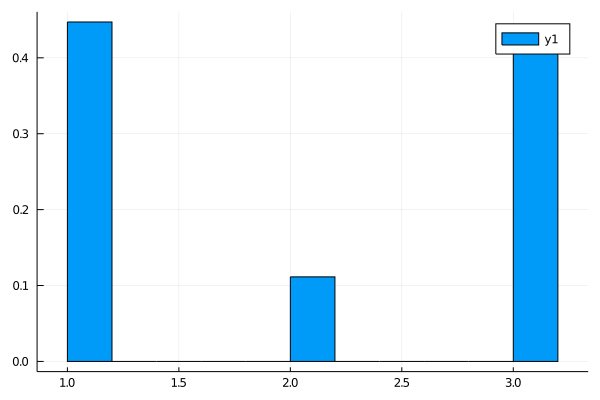

In [37]:
show_results(chain)

In [39]:
chain = run_two_agents_theory_of_mind(agent, agent, [1,9,2] , [1,9,2], [], [], -1)

Chains MCMC chain (10000×6×1 Array{Float64,3}):

Log evidence      = 0.0
Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = beta_opp[1], beta_opp[2], beta_opp[3], my_move, next_opp_move
internals         = lp

Summary Statistics
     parameters      mean       std   naive_se      mcse          ess      rha ⋯
         Symbol   Float64   Float64    Float64   Float64      Float64   Float6 ⋯

    beta_opp[1]    0.0835    0.0769     0.0008    0.0007    9794.4131    1.000 ⋯
    beta_opp[2]    0.7491    0.1199     0.0012    0.0011    9619.1302    1.000 ⋯
    beta_opp[3]    0.1674    0.1044     0.0010    0.0009   10080.5907    0.999 ⋯
        my_move    2.5413    0.7797     0.0078    0.0084   10119.2696    0.999 ⋯
  next_opp_move    2.0900    0.4915     0.0049    0.0049   10027.1964    0.999 ⋯
                                                                1 column omitted

Quantiles
     parameters      2.5%     25.0%     50.0

10.705832668674233

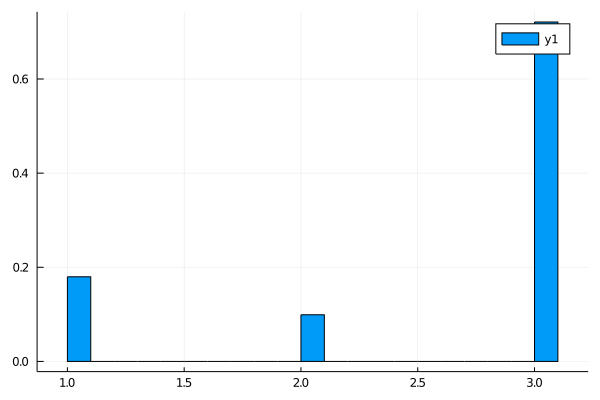

In [40]:
show_results(chain)

7.272742702856028

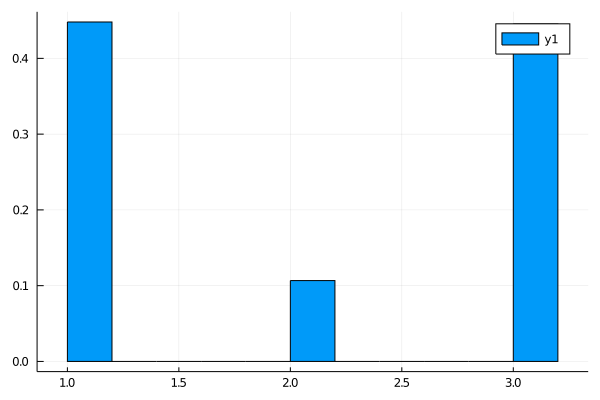

In [41]:
show_results(run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,1,1], [], [], 0))

7.197697575012887

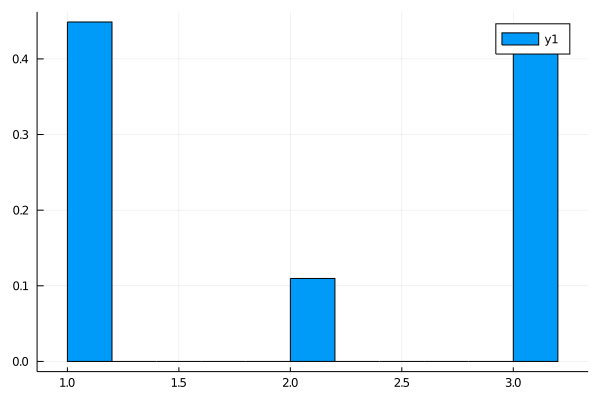

In [42]:
show_results(run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,1,1], [], [], 0))

1.460436006513103

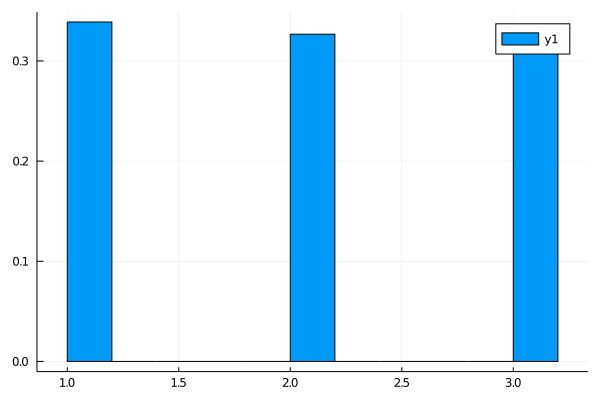

In [43]:
show_results(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 0))

## Depth 3

In [51]:
chain = run_two_agents_theory_of_mind(agent, agent,[1,5,5], [1,1,1], [], [], 3)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


Chains MCMC chain (10000×7×1 Array{Float64,3}):

Log evidence      = 0.0
Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = beta_opp[1], beta_opp[2], beta_opp[3], idx, my_move, next_opp_move
internals         = lp

Summary Statistics
     parameters        mean         std   naive_se      mcse          ess      ⋯
         Symbol     Float64     Float64    Float64   Float64      Float64   Fl ⋯

    beta_opp[1]      0.0919      0.0838     0.0008    0.0008    9357.7029    1 ⋯
    beta_opp[2]      0.4535      0.1419     0.0014    0.0015   10264.6762    1 ⋯
    beta_opp[3]      0.4546      0.1425     0.0014    0.0015   10141.3900    1 ⋯
            idx   4960.4445   2893.6800    28.9368   28.3146    9329.6725    1 ⋯
        my_move      1.9811      0.8682     0.0087    0.0080   10288.2986    1 ⋯
  next_opp_move      2.1487      0.7798     0.0078    0.0077    9686.2533    0 ⋯
                                                  

In [64]:
std(chain[:lp])

0.0

In [57]:
chain["beta_opp[1]"]

2-dimensional AxisArray{Float64,2,...} with axes:
    :iter, 1:1:10000
    :chain, 1:1
And data, a 10000×1 Array{Float64,2}:
 0.2457063557468964
 0.1862559700889291
 0.008031784171283815
 0.029915123621415622
 0.36526860271132067
 0.08373466610301179
 0.1499650921858409
 0.07537861029327936
 0.2342173549117789
 0.06949355590458453
 0.007561657035034447
 0.016292926357407294
 0.03393356577777269
 ⋮
 0.14135034915704495
 0.03644444714991762
 0.021161878737176766
 0.28488649264606636
 0.1157821035807613
 0.16323476193986494
 0.008821585049481197
 0.022815462934101468
 0.04136805849030012
 0.19164336902498091
 0.017970867455138078
 0.0517029329392908

1.4603204304862887

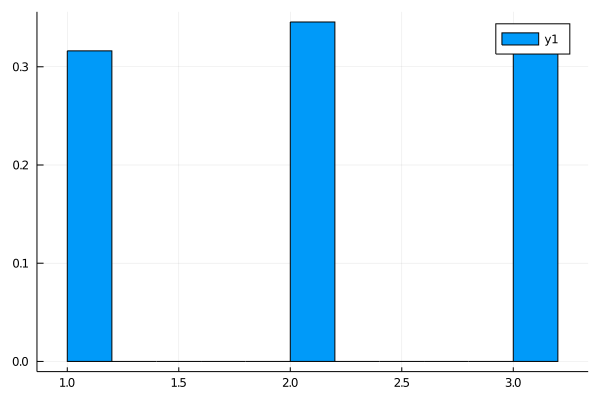

In [45]:
show_results(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 3,false))

## Depth 10

Progress: 100%|█████████████████████████████████████████| Time: 0:01:39


7.095887383817027

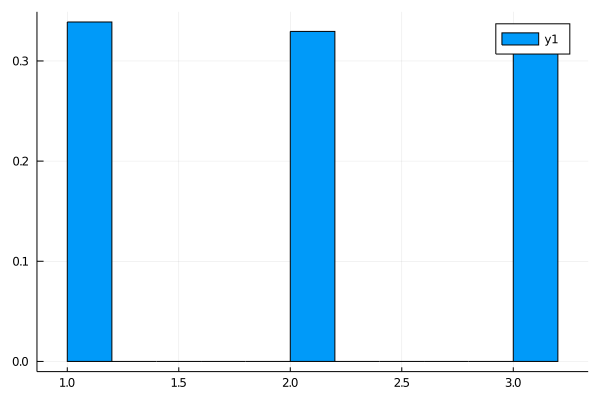

In [46]:
show_results(run_two_agents_theory_of_mind(agent, agent, [1,5,5], [1,1,1], [], [], 10))

In [47]:
show_results(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 10))

Progress:  60%|█████████████████████████                |  ETA: 0:00:37

LoadError: InterruptException:

## Depth 20

In [48]:
show_results(run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,1,1], [], [], 20))

LoadError: InterruptException:

In [49]:
show_results(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 20))

Progress:   5%|███                                      |  ETA: 0:00:56

LoadError: InterruptException:

# Simulations

In [12]:
function sample_move(chn)
    weights = exp.(chn[:lp][:, 1])
    weights = Weights(weights/sum(weights))
    idx = sample(collect(1:length(weights)), weights)
    move_sample = chn[:my_move][idx, 1]
    return move_sample
end

sample_move (generic function with 1 method)

In [13]:
function move(agent, other_agent, other_agent_history, my_history, other_player_prior, my_depth=1)
    other_agent_history = length(other_agent_history) > 0 ? other_agent_history : [1]
    other_agent_history = Array{Int}(other_agent_history)
    my_history = length(my_history) > 0 ? my_history : [1]
    my_history = Array{Int}(my_history)
    m = agent(other_agent, other_agent_history, other_player_prior, my_depth)
    chain = run_two_agents_theory_of_mind(agent, other_agent, other_player_prior, [1,1,1] , other_agent_history, my_history, my_depth, false)
    return sample_move(chain), compute_kldivergence_from_nash_eq(chain)
end

move (generic function with 2 methods)

In [14]:
function game(first_player_depth = 1, second_player_depth = 1, first_player_prior_policy = [1,1,1] , second_player_prior_policy = [1, 1, 1])
    first_player = agent
    second_player = agent
    num_of_rounds = 50
    first_player_history = []
    second_player_history = []
    kldivergence_first_player = []
    kldivergence_second_player = []
    @showprogress for i in 1:num_of_rounds
        m1, kld_1 = move(first_player, second_player, second_player_history, first_player_history, second_player_prior_policy, first_player_depth)
        push!(first_player_history, m1)
        push!(kldivergence_first_player, kld_1)
        m2, kld_2 = move(second_player, first_player, first_player_history, second_player_history, first_player_prior_policy, second_player_depth)
        push!(second_player_history, m2)
        push!(kldivergence_second_player, kld_2)
    end
    return first_player_history, second_player_history, kldivergence_first_player, kldivergence_second_player
 end

game (generic function with 5 methods)

In [15]:
function score(history)
    first_player_history, second_player_history, _ , _ = history
    first_wins = 0
    ties = 0
    second_wins = 0
    wins = Dict(1 => 3, 2 => 1, 3 => 2)
    for i in 1:length(first_player_history)
        if wins[first_player_history[i]] == second_player_history[i]
            second_wins += 1
        elseif wins[second_player_history[i]] == first_player_history[i]
            first_wins += 1
        else
            ties += 1
        end
    end
    return [first_wins, ties, second_wins]
end

score (generic function with 1 method)

In [53]:
NUM_OF_MC_SIMULATIONS = 100
function mc_simulation(first_policy, second_policy)
    first_weights = Weights(first_policy/sum(first_policy))
    first_moves = sample(collect(1:length(first_weights)), first_weights, NUM_OF_MC_SIMULATIONS)
    second_weights = Weights(second_policy/sum(second_policy))
    second_moves = sample(collect(1:length(second_weights)), second_weights, NUM_OF_MC_SIMULATIONS)
    first, tie, second = score([first_moves, second_moves, [], []])
    return (first - second) / NUM_OF_MC_SIMULATIONS
end

mc_simulation (generic function with 1 method)

In [59]:
mc_simulation([1,1,1], [1,1,10])

0.52

In [57]:
function accumulated_score(history)
    first_player_history, second_player_history, _ , _ = history
    first_wins, ties, second_wins = 0, 0, 0
    acc_result = []
    wins = Dict(1 => 3, 2 => 1, 3 => 2)
    for i in 1:length(first_player_history)
        if wins[first_player_history[i]] == second_player_history[i]
            second_wins += 1
        elseif wins[second_player_history[i]] == first_player_history[i]
            first_wins += 1
        else
            ties += 1
        end
        push!(acc_result, [first_wins, ties, second_wins])
    end
    return acc_result
end

accumulated_score (generic function with 1 method)

In [17]:
function plot_accumulated_score(acc_result)
    n = length(acc_result)
    acc_result = transpose(reduce(hcat, acc_result))
    plot(1:n, acc_result, alpha = 0.3)
end

plot_accumulated_score (generic function with 1 method)

In [18]:
function display_score(score)
    num_of_wins_first, num_of_ties, num_of_wins_second = score
    println("first player won: $num_of_wins_first")
    println("second player won: $num_of_wins_second") 
    println("ties: $num_of_ties") 
end

display_score (generic function with 1 method)

In [19]:
NUM_OF_EXPIREMENTS = 15

15

In [20]:
function mean_and_var(results)
    results = reduce(hcat, results)
    mean_results = mean(results,dims=2)
    var_results = std(results,dims=2)
    return mean_results , var_results
end

mean_and_var (generic function with 1 method)

In [21]:
function simulate_game(first_player_depth = 1, second_player_depth = 1, first_player_prior_policy = [1,1,1] , second_player_prior_policy = [1, 1, 1], num_of_expirements = 10)
    result_plt = plot(title = "Game Results")
    kl_plt = plot(title = "Distance from Nash-eq (in KL-divergence)")
    scores = []
    for i in 1:num_of_expirements
        game_result = game(first_player_depth,second_player_depth, first_player_prior_policy, second_player_prior_policy)
        acc_result = accumulated_score(game_result)
        score_result = score(game_result)
        push!(scores,score_result)
        n = length(acc_result)
        acc_result = transpose(reduce(hcat, acc_result))
        plot!(result_plt, acc_result, alpha = 0.3, legend = false, label = ["p1 wins" "ties" "p2 wins"] , color = [1 2 3])
        
        _ , _ , first_kl_div, second_kl_div = game_result
        plot!(kl_plt, [first_kl_div, second_kl_div] , alpha = 0.3, legend = false, label= ["p1 dist" "p2 dist"], color = [1 2])
    end
    display(result_plt)
    mean_results, var_results = mean_and_var(scores)
    println("first win: $(mean_results[1])+-$(var_results[1])")
    println("ties: $(mean_results[2])+-$(var_results[2])")
    println("second win: $(mean_results[3])+-$(var_results[3])")
    display(kl_plt)
end 

simulate_game (generic function with 6 methods)

Progress: 100%|█████████████████████████████████████████| Time: 0:04:54
Progress: 100%|█████████████████████████████████████████| Time: 0:04:37
Progress: 100%|█████████████████████████████████████████| Time: 0:04:20
Progress: 100%|█████████████████████████████████████████| Time: 0:03:37
Progress: 100%|█████████████████████████████████████████| Time: 0:02:47
Progress: 100%|█████████████████████████████████████████| Time: 0:02:47
Progress: 100%|█████████████████████████████████████████| Time: 0:03:54
Progress: 100%|█████████████████████████████████████████| Time: 0:03:19
Progress: 100%|█████████████████████████████████████████| Time: 0:02:48
Progress: 100%|█████████████████████████████████████████| Time: 0:02:47
Progress: 100%|█████████████████████████████████████████| Time: 0:02:47
Progress: 100%|█████████████████████████████████████████| Time: 0:02:47
Progress: 100%|█████████████████████████████████████████| Time: 0:02:44
Progress: 100%|█████████████████████████████████████████| Time: 

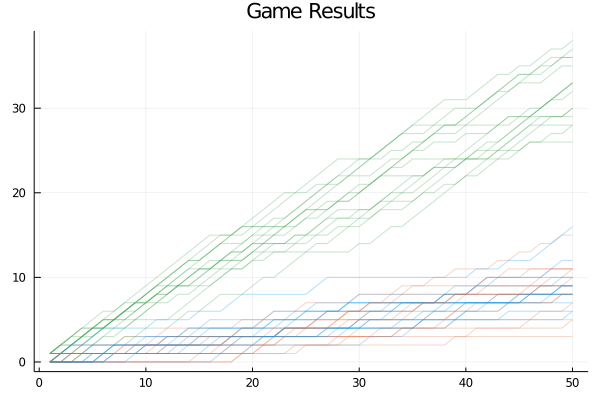

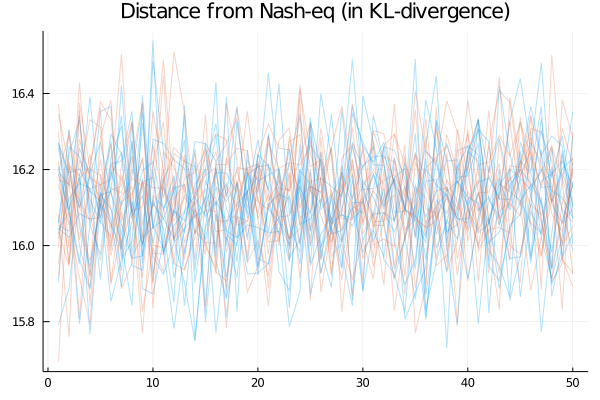

first win: 9.0+-2.4784787961282104
ties: 8.733333333333333+-3.0110906108363236
second win: 32.266666666666666+-3.6735865438612025


In [119]:
simulate_game(-1, -1, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:49
Progress: 100%|█████████████████████████████████████████| Time: 0:02:45
Progress: 100%|█████████████████████████████████████████| Time: 0:02:54
Progress: 100%|█████████████████████████████████████████| Time: 0:02:45
Progress: 100%|█████████████████████████████████████████| Time: 0:02:48
Progress: 100%|█████████████████████████████████████████| Time: 0:02:46
Progress: 100%|█████████████████████████████████████████| Time: 0:02:47
Progress: 100%|█████████████████████████████████████████| Time: 0:02:48
Progress: 100%|█████████████████████████████████████████| Time: 0:02:47
Progress: 100%|█████████████████████████████████████████| Time: 0:02:47
Progress: 100%|█████████████████████████████████████████| Time: 0:02:45
Progress: 100%|█████████████████████████████████████████| Time: 0:02:44
Progress: 100%|█████████████████████████████████████████| Time: 0:02:45
Progress: 100%|█████████████████████████████████████████| Time: 

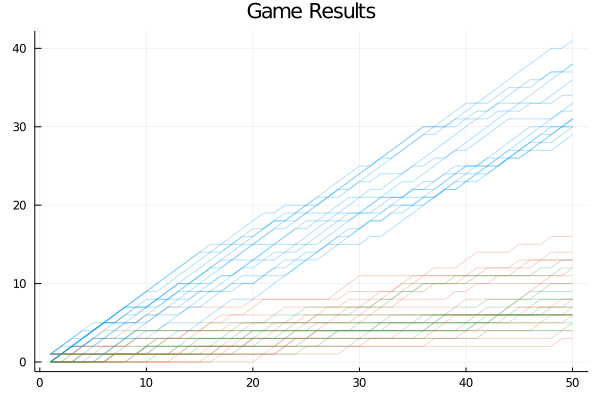

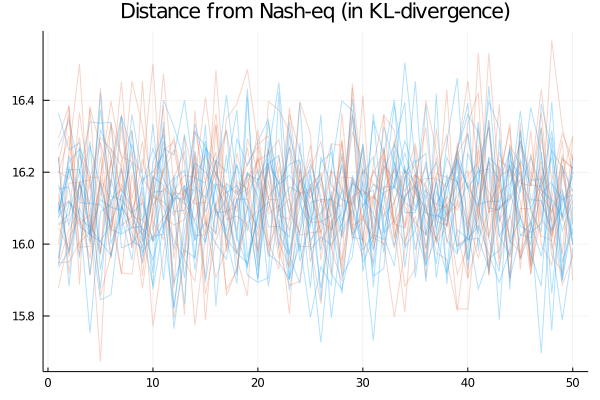

first win: 33.4+-3.7186787208054732
ties: 9.133333333333333+-3.9072582032246936
second win: 7.466666666666667+-2.587515815456612


In [120]:
simulate_game(-1, -1, [10,1,1], [1,1,10], NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:33
Progress: 100%|█████████████████████████████████████████| Time: 0:03:34
Progress: 100%|█████████████████████████████████████████| Time: 0:03:33
Progress: 100%|█████████████████████████████████████████| Time: 0:03:34
Progress: 100%|█████████████████████████████████████████| Time: 0:03:34
Progress: 100%|█████████████████████████████████████████| Time: 0:03:33
Progress: 100%|█████████████████████████████████████████| Time: 0:03:33
Progress: 100%|█████████████████████████████████████████| Time: 0:03:34
Progress: 100%|█████████████████████████████████████████| Time: 0:03:35
Progress: 100%|█████████████████████████████████████████| Time: 0:03:34
Progress: 100%|█████████████████████████████████████████| Time: 0:03:33
Progress: 100%|█████████████████████████████████████████| Time: 0:03:33
Progress: 100%|█████████████████████████████████████████| Time: 0:03:24
Progress: 100%|█████████████████████████████████████████| Time: 

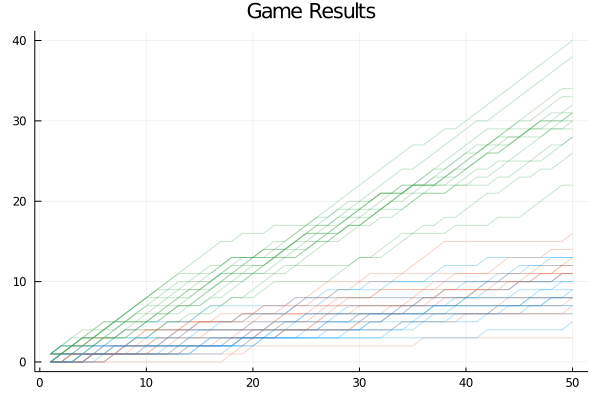

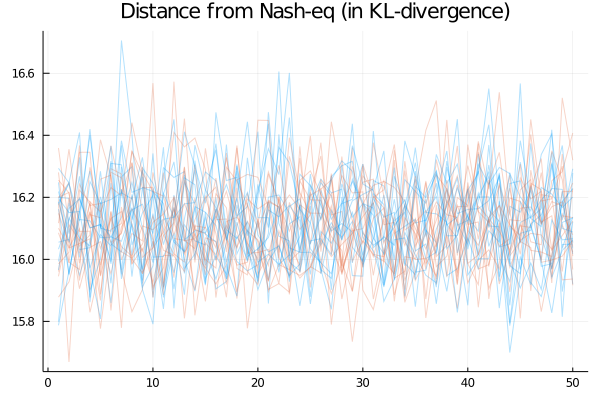

first win: 9.066666666666666+-2.4338877385388016
ties: 10.066666666666666+-3.369329451445933
second win: 30.866666666666667+-4.421807430495018


In [121]:
simulate_game(0, -1, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:44
Progress: 100%|█████████████████████████████████████████| Time: 0:03:34
Progress: 100%|█████████████████████████████████████████| Time: 0:03:32
Progress: 100%|█████████████████████████████████████████| Time: 0:03:32
Progress: 100%|█████████████████████████████████████████| Time: 0:03:31
Progress: 100%|█████████████████████████████████████████| Time: 0:04:48
Progress: 100%|█████████████████████████████████████████| Time: 0:04:55
Progress: 100%|█████████████████████████████████████████| Time: 0:04:53
Progress: 100%|█████████████████████████████████████████| Time: 0:04:54
Progress: 100%|█████████████████████████████████████████| Time: 0:04:56
Progress: 100%|█████████████████████████████████████████| Time: 8:11:15m36
Progress: 100%|█████████████████████████████████████████| Time: 0:03:50
Progress: 100%|█████████████████████████████████████████| Time: 0:03:57
Progress: 100%|█████████████████████████████████████████| Tim

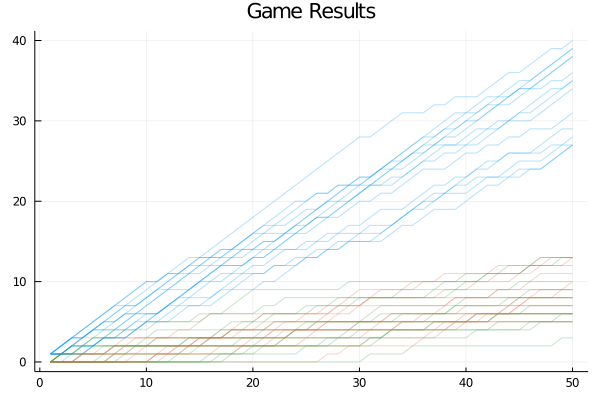

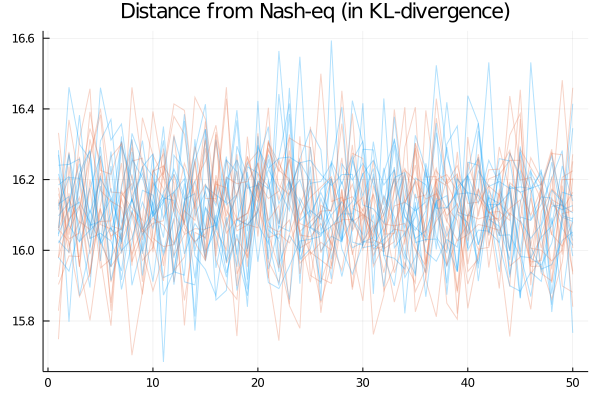

first win: 33.53333333333333+-4.911599487316685
ties: 8.666666666666666+-2.819996622760558
second win: 7.8+-3.051931472737505


In [34]:
simulate_game(-1, 0, [10,1,1], [1,1,10], NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:04:25
Progress: 100%|█████████████████████████████████████████| Time: 0:04:32
Progress: 100%|█████████████████████████████████████████| Time: 0:04:20
Progress: 100%|█████████████████████████████████████████| Time: 0:05:15
Progress: 100%|█████████████████████████████████████████| Time: 0:04:33
Progress: 100%|█████████████████████████████████████████| Time: 0:04:59
Progress: 100%|█████████████████████████████████████████| Time: 0:04:52
Progress: 100%|█████████████████████████████████████████| Time: 0:05:33
Progress: 100%|█████████████████████████████████████████| Time: 0:05:04
Progress: 100%|█████████████████████████████████████████| Time: 0:04:40
Progress: 100%|█████████████████████████████████████████| Time: 0:04:25
Progress: 100%|█████████████████████████████████████████| Time: 0:04:25
Progress: 100%|█████████████████████████████████████████| Time: 0:04:39
Progress: 100%|█████████████████████████████████████████| Time: 

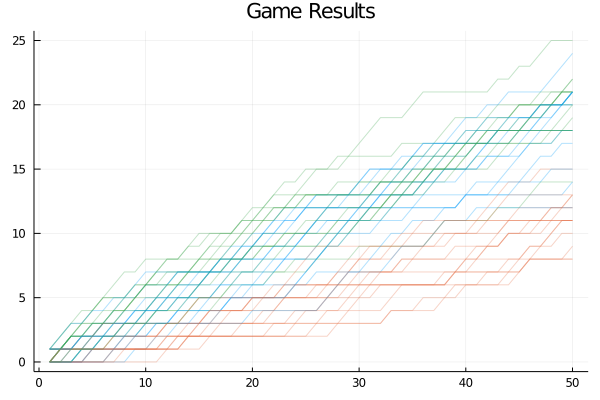

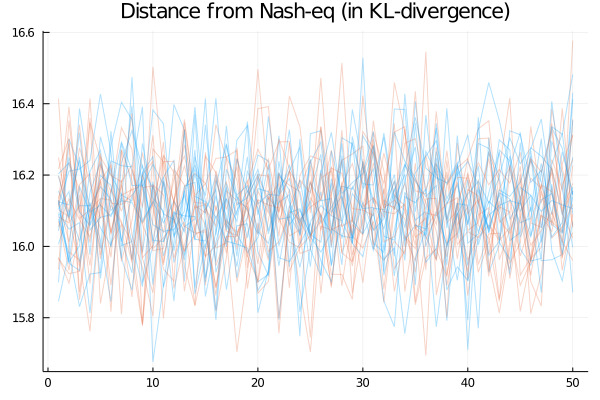

first win: 18.733333333333334+-3.1952345468719208
ties: 11.2+-1.9346465162548796
second win: 20.066666666666666+-2.491891612715892


In [35]:
simulate_game(0, 0, [1,10,1] , [1, 1, 10],NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:04:23
Progress: 100%|█████████████████████████████████████████| Time: 0:04:21
Progress: 100%|█████████████████████████████████████████| Time: 0:04:22
Progress: 100%|█████████████████████████████████████████| Time: 0:04:24
Progress: 100%|█████████████████████████████████████████| Time: 0:04:24
Progress: 100%|█████████████████████████████████████████| Time: 0:04:17
Progress: 100%|█████████████████████████████████████████| Time: 0:04:17
Progress: 100%|█████████████████████████████████████████| Time: 0:04:18
Progress: 100%|█████████████████████████████████████████| Time: 0:04:16
Progress: 100%|█████████████████████████████████████████| Time: 0:04:17
Progress: 100%|█████████████████████████████████████████| Time: 0:04:17
Progress: 100%|█████████████████████████████████████████| Time: 0:04:19
Progress: 100%|█████████████████████████████████████████| Time: 0:04:18
Progress: 100%|█████████████████████████████████████████| Time: 

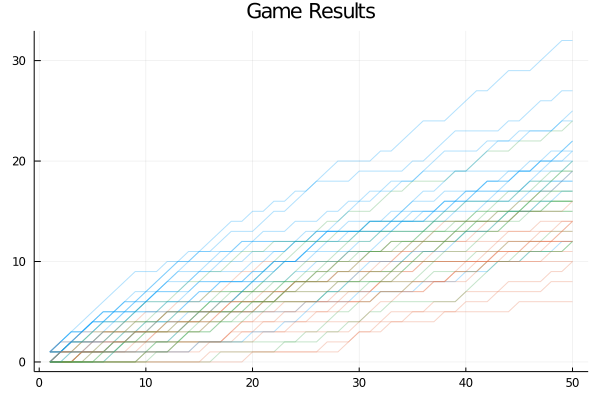

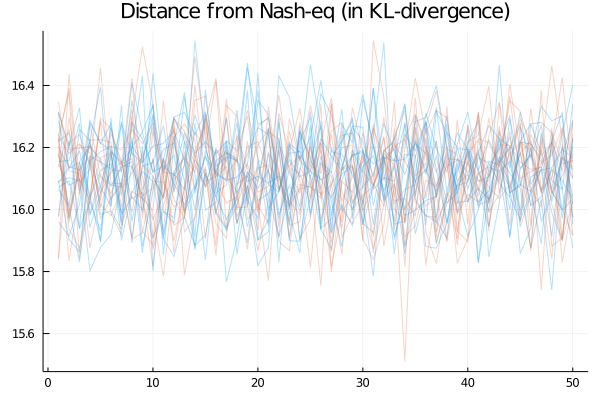

first win: 21.2+-4.662923668993215
ties: 12.333333333333334+-3.1773004414499577
second win: 16.466666666666665+-3.159264531651691


In [36]:
simulate_game(0, 0, [10,1,1] , [1, 1, 10],NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:10:11
Progress: 100%|█████████████████████████████████████████| Time: 0:10:08
Progress: 100%|█████████████████████████████████████████| Time: 0:10:03
Progress: 100%|█████████████████████████████████████████| Time: 0:10:00
Progress: 100%|█████████████████████████████████████████| Time: 0:10:00
Progress: 100%|█████████████████████████████████████████| Time: 0:10:01
Progress: 100%|█████████████████████████████████████████| Time: 0:10:05
Progress: 100%|█████████████████████████████████████████| Time: 0:10:10
Progress: 100%|█████████████████████████████████████████| Time: 0:10:13
Progress: 100%|█████████████████████████████████████████| Time: 0:10:15
Progress: 100%|█████████████████████████████████████████| Time: 0:10:02
Progress: 100%|█████████████████████████████████████████| Time: 0:09:58
Progress: 100%|█████████████████████████████████████████| Time: 0:10:00
Progress: 100%|█████████████████████████████████████████| Time: 

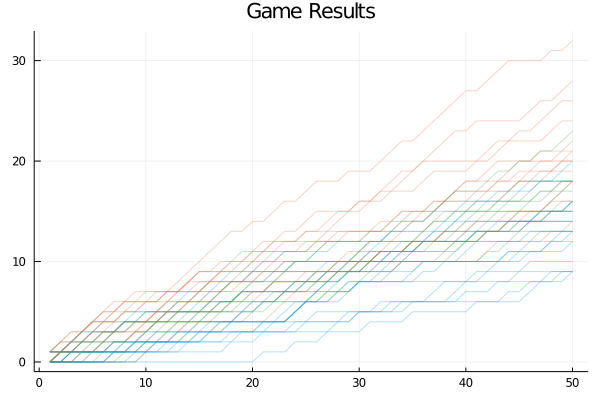

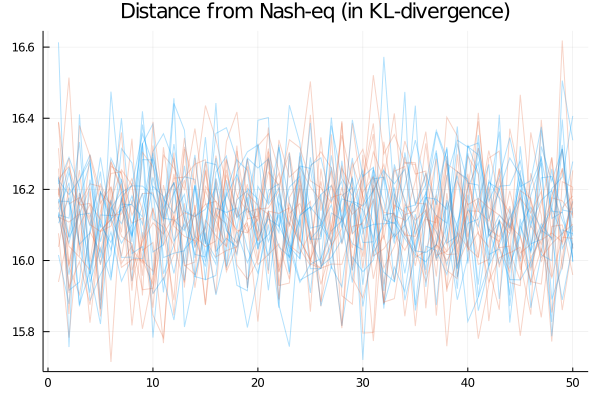

first win: 13.266666666666667+-3.3266599866332403
ties: 20.8+-5.03133041195723
second win: 15.933333333333334+-3.2396354880199247


In [37]:
simulate_game(0, 1, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:10:14
Progress: 100%|█████████████████████████████████████████| Time: 0:10:00
Progress: 100%|█████████████████████████████████████████| Time: 0:09:59
Progress: 100%|█████████████████████████████████████████| Time: 0:09:57
Progress: 100%|█████████████████████████████████████████| Time: 0:09:55
Progress: 100%|█████████████████████████████████████████| Time: 0:09:57
Progress: 100%|█████████████████████████████████████████| Time: 0:09:57
Progress: 100%|█████████████████████████████████████████| Time: 0:09:55
Progress: 100%|█████████████████████████████████████████| Time: 0:09:59
Progress: 100%|█████████████████████████████████████████| Time: 0:09:57
Progress: 100%|█████████████████████████████████████████| Time: 0:09:55
Progress: 100%|█████████████████████████████████████████| Time: 0:10:05
Progress: 100%|█████████████████████████████████████████| Time: 0:09:42
Progress: 100%|█████████████████████████████████████████| Time: 

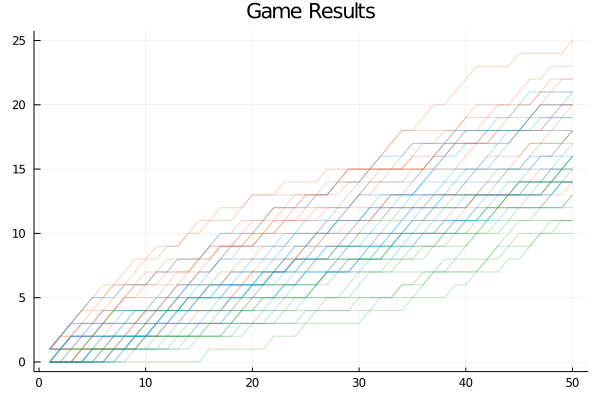

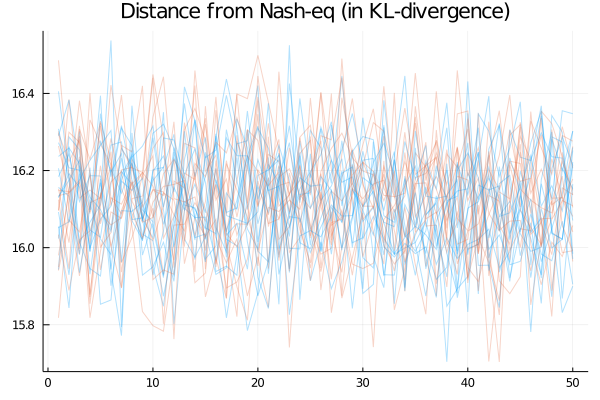

first win: 16.866666666666667+-2.799659843283687
ties: 19.333333333333332+-3.1773004414499573
second win: 13.8+-2.336052836975837


In [38]:
simulate_game(1, 0, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:15:42
Progress: 100%|█████████████████████████████████████████| Time: 0:15:42
Progress: 100%|█████████████████████████████████████████| Time: 0:15:49
Progress: 100%|█████████████████████████████████████████| Time: 0:15:45
Progress: 100%|█████████████████████████████████████████| Time: 0:15:43
Progress: 100%|█████████████████████████████████████████| Time: 0:15:38
Progress: 100%|█████████████████████████████████████████| Time: 0:15:36
Progress: 100%|█████████████████████████████████████████| Time: 0:15:30
Progress: 100%|█████████████████████████████████████████| Time: 0:15:30
Progress: 100%|█████████████████████████████████████████| Time: 0:15:30
Progress: 100%|█████████████████████████████████████████| Time: 0:15:45
Progress: 100%|█████████████████████████████████████████| Time: 0:15:44
Progress: 100%|█████████████████████████████████████████| Time: 0:15:38
Progress: 100%|█████████████████████████████████████████| Time: 

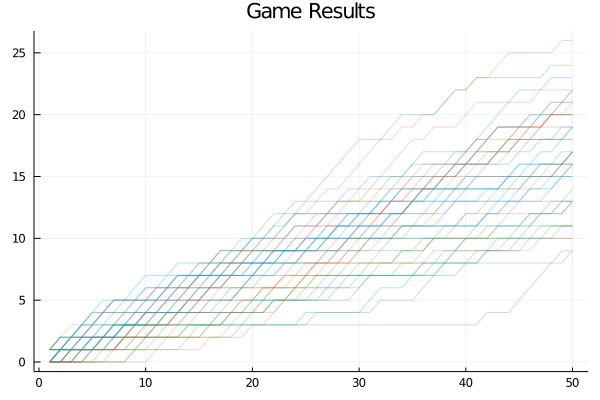

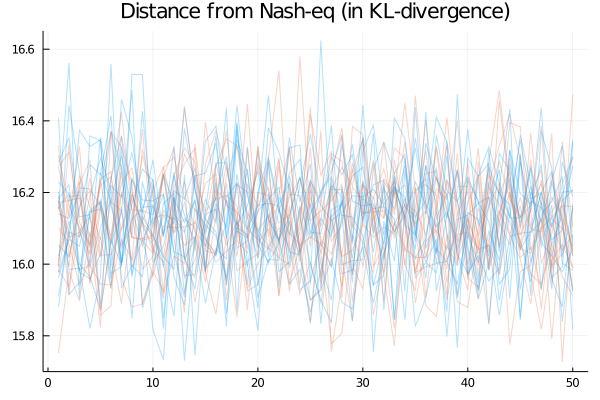

first win: 17.4+-3.0425553170226594
ties: 18.533333333333335+-4.155317877932646
second win: 14.066666666666666+-4.447578260239203


In [39]:
simulate_game(1, 1, [10,1,1] , [1, 1, 10],NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:15:30
Progress: 100%|█████████████████████████████████████████| Time: 0:15:35
Progress: 100%|█████████████████████████████████████████| Time: 0:15:28
Progress: 100%|█████████████████████████████████████████| Time: 0:15:28
Progress: 100%|█████████████████████████████████████████| Time: 0:15:27
Progress: 100%|█████████████████████████████████████████| Time: 0:15:43
Progress: 100%|█████████████████████████████████████████| Time: 0:15:39
Progress: 100%|█████████████████████████████████████████| Time: 0:15:37
Progress: 100%|█████████████████████████████████████████| Time: 0:15:32
Progress: 100%|█████████████████████████████████████████| Time: 0:15:24
Progress: 100%|█████████████████████████████████████████| Time: 0:15:25
Progress: 100%|█████████████████████████████████████████| Time: 0:15:29
Progress: 100%|█████████████████████████████████████████| Time: 0:15:25
Progress: 100%|█████████████████████████████████████████| Time: 

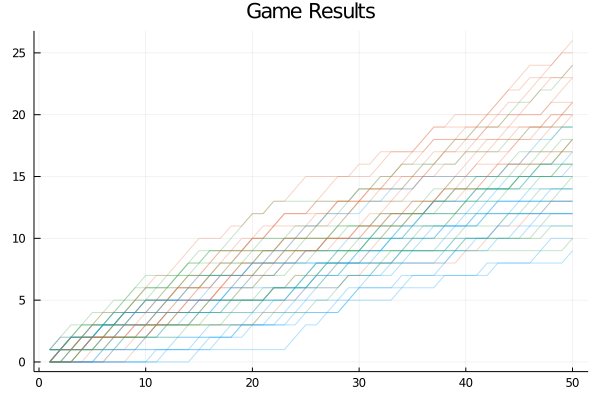

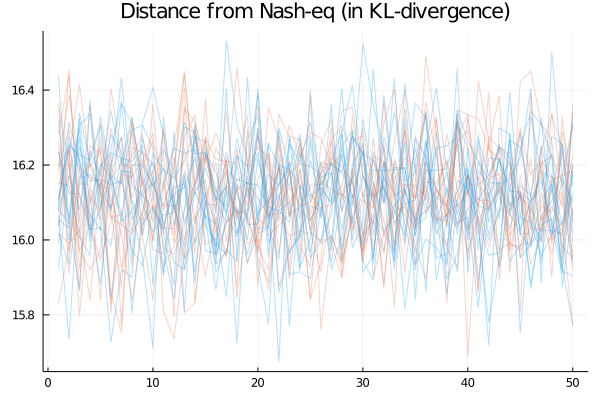

first win: 13.333333333333334+-2.6367367999823097
ties: 20.666666666666668+-3.3523268393901033
second win: 16.0+-3.5254179083580186


In [40]:
simulate_game(1, 1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:20:38
Progress: 100%|█████████████████████████████████████████| Time: 0:20:41
Progress: 100%|█████████████████████████████████████████| Time: 0:20:41
Progress: 100%|█████████████████████████████████████████| Time: 0:20:45
Progress: 100%|█████████████████████████████████████████| Time: 0:20:45
Progress: 100%|█████████████████████████████████████████| Time: 0:20:43
Progress: 100%|█████████████████████████████████████████| Time: 0:20:29
Progress: 100%|█████████████████████████████████████████| Time: 0:19:58
Progress: 100%|█████████████████████████████████████████| Time: 0:20:25
Progress: 100%|█████████████████████████████████████████| Time: 0:28:06
Progress: 100%|█████████████████████████████████████████| Time: 0:24:36
Progress: 100%|█████████████████████████████████████████| Time: 0:21:33
Progress: 100%|█████████████████████████████████████████| Time: 0:20:46
Progress: 100%|█████████████████████████████████████████| Time: 

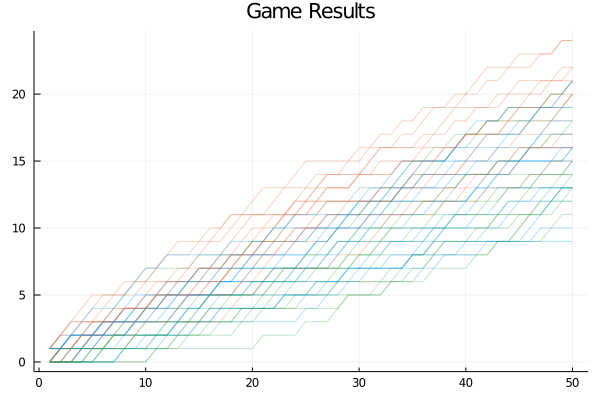

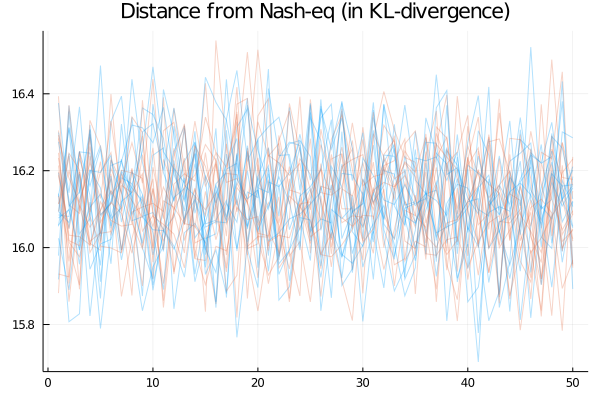

first win: 15.133333333333333+-3.4406533155921477
ties: 19.533333333333335+-2.8999178970315365
second win: 15.333333333333334+-3.2219485379118615


In [41]:
simulate_game(2, 1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:20:46
Progress: 100%|█████████████████████████████████████████| Time: 0:20:49
Progress: 100%|█████████████████████████████████████████| Time: 0:20:52
Progress: 100%|█████████████████████████████████████████| Time: 0:20:49
Progress: 100%|█████████████████████████████████████████| Time: 0:20:51
Progress: 100%|█████████████████████████████████████████| Time: 0:20:50
Progress: 100%|█████████████████████████████████████████| Time: 0:20:54
Progress: 100%|█████████████████████████████████████████| Time: 0:22:12
Progress: 100%|█████████████████████████████████████████| Time: 0:21:17
Progress: 100%|█████████████████████████████████████████| Time: 0:21:17
Progress: 100%|█████████████████████████████████████████| Time: 0:20:51
Progress: 100%|█████████████████████████████████████████| Time: 0:20:54
Progress: 100%|█████████████████████████████████████████| Time: 0:20:49
Progress: 100%|█████████████████████████████████████████| Time: 

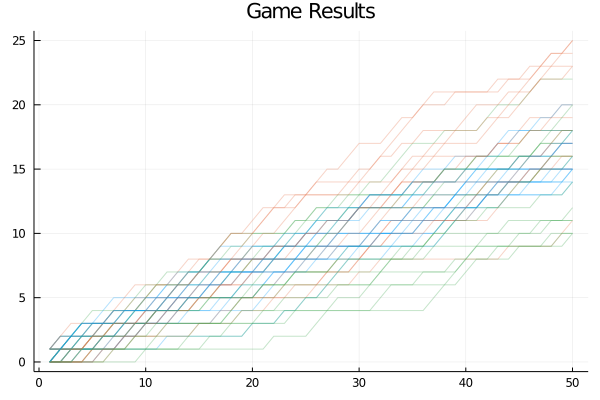

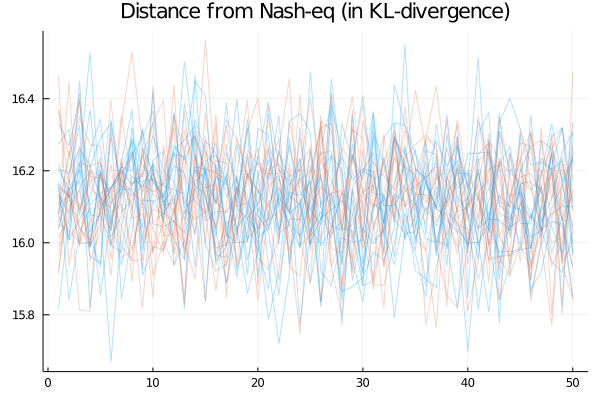

first win: 16.066666666666666+-1.709915063331955
ties: 19.133333333333333+-4.12079511513887
second win: 14.8+-3.96772694913059


In [42]:
simulate_game(1, 2, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:26:00
Progress: 100%|█████████████████████████████████████████| Time: 0:25:59
Progress: 100%|█████████████████████████████████████████| Time: 0:26:02
Progress: 100%|█████████████████████████████████████████| Time: 0:25:59
Progress: 100%|█████████████████████████████████████████| Time: 0:26:03
Progress: 100%|█████████████████████████████████████████| Time: 0:26:01
Progress: 100%|█████████████████████████████████████████| Time: 0:26:03
Progress: 100%|█████████████████████████████████████████| Time: 0:26:10
Progress: 100%|█████████████████████████████████████████| Time: 0:26:01
Progress: 100%|█████████████████████████████████████████| Time: 0:26:05
Progress: 100%|█████████████████████████████████████████| Time: 0:26:03
Progress: 100%|█████████████████████████████████████████| Time: 0:26:00
Progress: 100%|█████████████████████████████████████████| Time: 0:26:06
Progress: 100%|█████████████████████████████████████████| Time: 

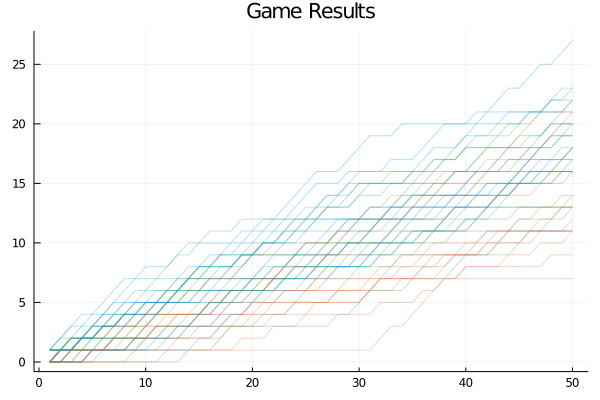

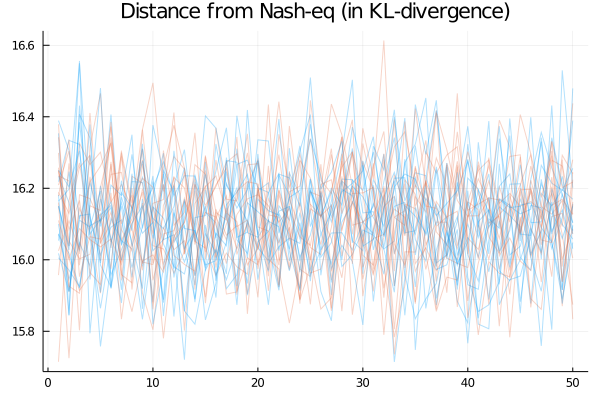

first win: 18.8+-3.726354020448713
ties: 14.0+-4.423960733486292
second win: 17.2+-3.468223093829379


In [43]:
simulate_game(2, 2, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:26:05
Progress: 100%|█████████████████████████████████████████| Time: 0:26:09
Progress: 100%|█████████████████████████████████████████| Time: 0:26:16
Progress: 100%|█████████████████████████████████████████| Time: 0:26:05
Progress: 100%|█████████████████████████████████████████| Time: 0:25:59
Progress: 100%|█████████████████████████████████████████| Time: 0:26:19
Progress: 100%|█████████████████████████████████████████| Time: 0:26:02
Progress: 100%|█████████████████████████████████████████| Time: 0:26:03
Progress: 100%|█████████████████████████████████████████| Time: 0:26:00
Progress: 100%|█████████████████████████████████████████| Time: 0:26:03
Progress: 100%|█████████████████████████████████████████| Time: 0:26:01
Progress: 100%|█████████████████████████████████████████| Time: 0:26:05
Progress: 100%|█████████████████████████████████████████| Time: 0:26:18
Progress: 100%|█████████████████████████████████████████| Time: 

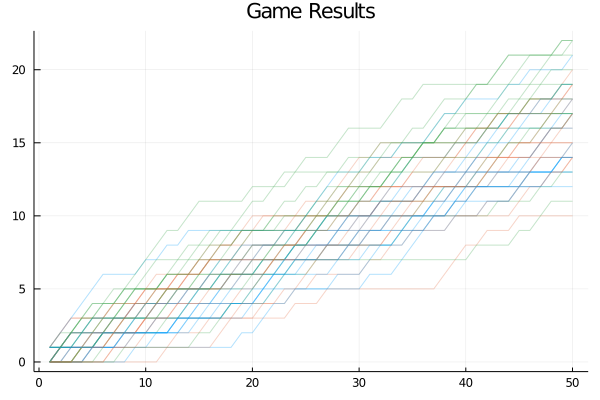

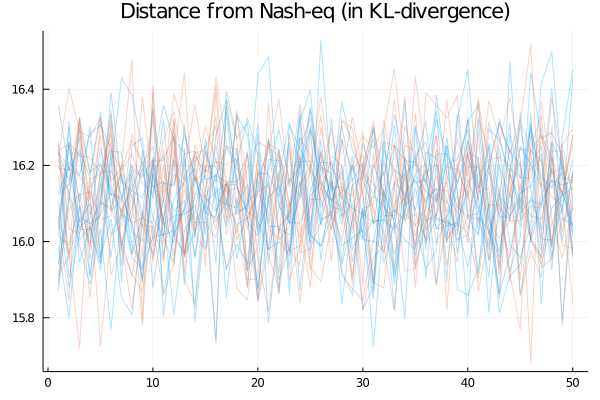

first win: 15.666666666666666+-2.581988897471611
ties: 16.066666666666666+-2.6040261866871424
second win: 18.266666666666666+-3.172801075810878


In [44]:
simulate_game(2, 2, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:15:13
Progress: 100%|█████████████████████████████████████████| Time: 0:15:10
Progress: 100%|█████████████████████████████████████████| Time: 0:15:05
Progress: 100%|█████████████████████████████████████████| Time: 0:15:15
Progress: 100%|█████████████████████████████████████████| Time: 0:15:13
Progress: 100%|█████████████████████████████████████████| Time: 0:15:09
Progress: 100%|█████████████████████████████████████████| Time: 0:15:07
Progress: 100%|█████████████████████████████████████████| Time: 0:15:11
Progress: 100%|█████████████████████████████████████████| Time: 0:15:11
Progress: 100%|█████████████████████████████████████████| Time: 0:15:14
Progress: 100%|█████████████████████████████████████████| Time: 0:15:13
Progress: 100%|█████████████████████████████████████████| Time: 0:15:10
Progress: 100%|█████████████████████████████████████████| Time: 0:15:07
Progress: 100%|█████████████████████████████████████████| Time: 

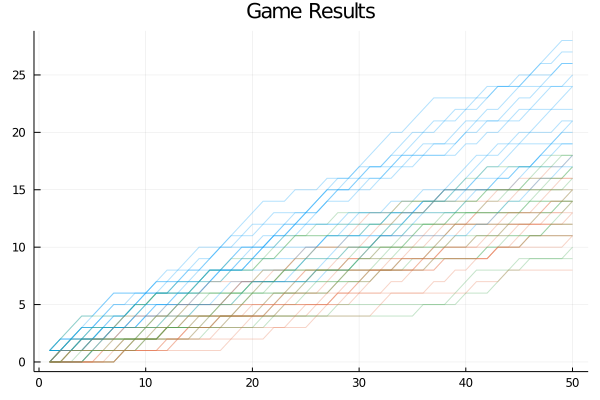

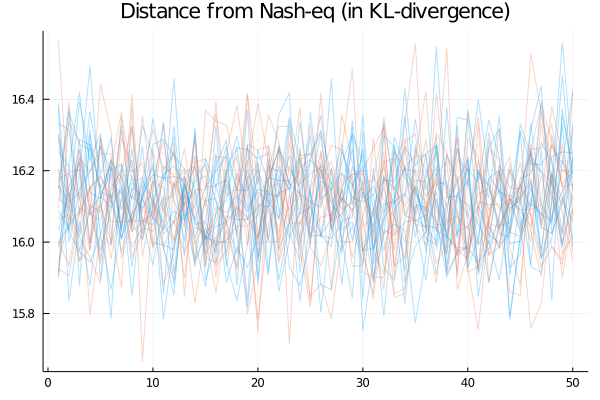

first win: 22.466666666666665+-3.5023801430836525
ties: 13.266666666666667+-2.5485756993344526
second win: 14.266666666666667+-2.7894358535288784


In [45]:
simulate_game(2, 0, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:14:00
Progress: 100%|█████████████████████████████████████████| Time: 0:14:00
Progress: 100%|█████████████████████████████████████████| Time: 0:13:56
Progress: 100%|█████████████████████████████████████████| Time: 0:14:09
Progress: 100%|█████████████████████████████████████████| Time: 0:14:00
Progress: 100%|█████████████████████████████████████████| Time: 0:13:58
Progress: 100%|█████████████████████████████████████████| Time: 0:14:02
Progress: 100%|█████████████████████████████████████████| Time: 0:14:00
Progress: 100%|█████████████████████████████████████████| Time: 0:13:59
Progress: 100%|█████████████████████████████████████████| Time: 0:14:05
Progress: 100%|█████████████████████████████████████████| Time: 0:14:01
Progress: 100%|█████████████████████████████████████████| Time: 0:14:02
Progress: 100%|█████████████████████████████████████████| Time: 0:14:00
Progress: 100%|█████████████████████████████████████████| Time: 

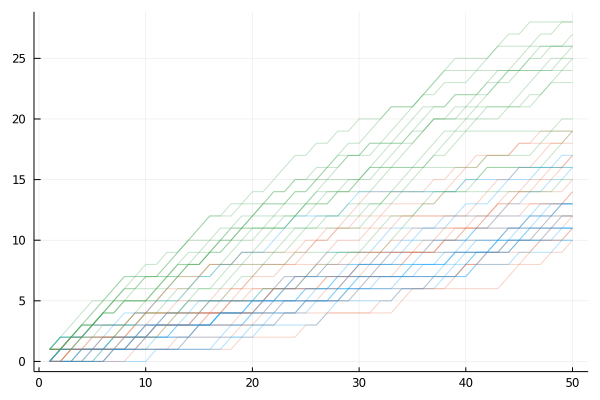

first win: 12.6+-2.1974010622941433
ties: 14.266666666666667+-3.0581662728473336
second win: 23.133333333333333+-4.273952113286562


In [ ]:
simulate_game(0, 2, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:18:41
Progress: 100%|█████████████████████████████████████████| Time: 0:18:34
Progress: 100%|█████████████████████████████████████████| Time: 0:18:46
Progress: 100%|█████████████████████████████████████████| Time: 0:18:34
Progress: 100%|█████████████████████████████████████████| Time: 0:18:37
Progress: 100%|█████████████████████████████████████████| Time: 0:18:35
Progress: 100%|█████████████████████████████████████████| Time: 0:18:34
Progress: 100%|█████████████████████████████████████████| Time: 0:18:36
Progress: 100%|█████████████████████████████████████████| Time: 0:18:37
Progress: 100%|█████████████████████████████████████████| Time: 0:18:43
Progress: 100%|█████████████████████████████████████████| Time: 0:18:36
Progress: 100%|█████████████████████████████████████████| Time: 0:18:37
Progress: 100%|█████████████████████████████████████████| Time: 0:18:40
Progress: 100%|█████████████████████████████████████████| Time: 

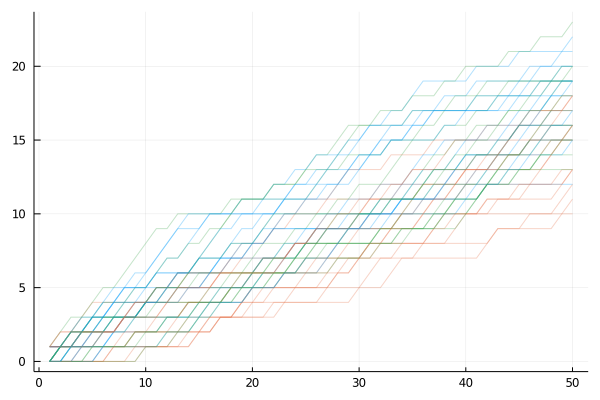

first win: 17.933333333333334+-2.631313269796951
ties: 14.733333333333333+-2.6040261866871424
second win: 17.333333333333332+-2.6903708365381966


In [ ]:
simulate_game(3, 0, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:20:38
Progress: 100%|█████████████████████████████████████████| Time: 0:18:18
Progress: 100%|█████████████████████████████████████████| Time: 0:18:37
Progress: 100%|█████████████████████████████████████████| Time: 0:20:15
Progress: 100%|█████████████████████████████████████████| Time: 0:18:53
Progress: 100%|█████████████████████████████████████████| Time: 0:18:35
Progress: 100%|█████████████████████████████████████████| Time: 0:18:31
Progress: 100%|█████████████████████████████████████████| Time: 0:18:32
Progress: 100%|█████████████████████████████████████████| Time: 0:18:31
Progress: 100%|█████████████████████████████████████████| Time: 0:18:34
Progress: 100%|█████████████████████████████████████████| Time: 0:18:32
Progress: 100%|█████████████████████████████████████████| Time: 0:18:32
Progress: 100%|█████████████████████████████████████████| Time: 0:18:33
Progress: 100%|█████████████████████████████████████████| Time: 

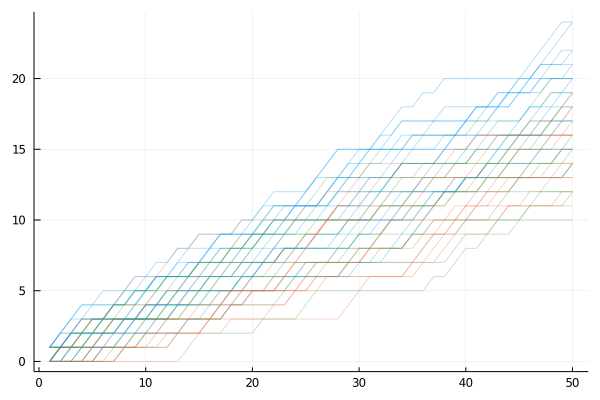

first win: 19.6+-2.9712912056160747
ties: 15.066666666666666+-2.3441924185608345
second win: 15.333333333333334+-2.9680841985233184


In [ ]:
simulate_game(0, 3, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:38:3939m
Progress: 100%|█████████████████████████████████████████| Time: 0:48:12
Progress: 100%|█████████████████████████████████████████| Time: 0:31:08
Progress: 100%|█████████████████████████████████████████| Time: 0:35:35
Progress: 100%|█████████████████████████████████████████| Time: 0:29:21
Progress: 100%|█████████████████████████████████████████| Time: 0:28:44
Progress: 100%|█████████████████████████████████████████| Time: 0:28:43
Progress: 100%|█████████████████████████████████████████| Time: 0:32:30
Progress: 100%|█████████████████████████████████████████| Time: 0:31:59
Progress: 100%|█████████████████████████████████████████| Time: 0:29:56███████████████████                 |  ETA: 0:11:57
Progress: 100%|█████████████████████████████████████████| Time: 0:32:19
Progress: 100%|█████████████████████████████████████████| Time: 0:31:47
Progress: 100%|█████████████████████████████████████████| Time: 0:32:39
Progress: 

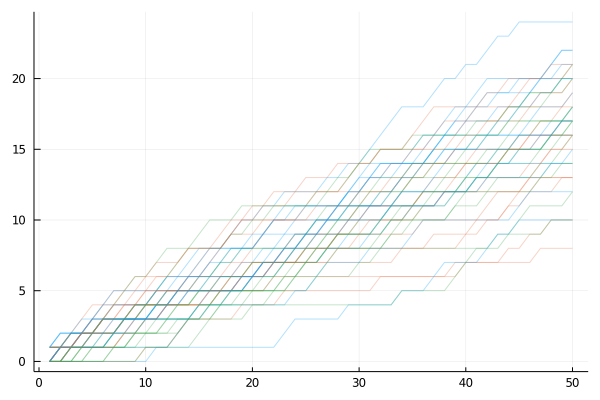

first win: 17.8+-3.931557306862366
ties: 15.733333333333333+-3.8446004188930187
second win: 16.466666666666665+-2.996823715361379


In [ ]:
simulate_game(2, 3, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:27:27
Progress: 100%|█████████████████████████████████████████| Time: 0:27:24
Progress: 100%|█████████████████████████████████████████| Time: 0:27:23
Progress: 100%|█████████████████████████████████████████| Time: 0:27:30
Progress: 100%|█████████████████████████████████████████| Time: 0:27:33
Progress: 100%|█████████████████████████████████████████| Time: 0:27:34
Progress: 100%|█████████████████████████████████████████| Time: 0:27:25
Progress: 100%|█████████████████████████████████████████| Time: 0:27:35
Progress: 100%|█████████████████████████████████████████| Time: 0:27:23
Progress: 100%|█████████████████████████████████████████| Time: 0:27:26
Progress: 100%|█████████████████████████████████████████| Time: 0:28:18
Progress: 100%|█████████████████████████████████████████| Time: 0:28:49
Progress: 100%|█████████████████████████████████████████| Time: 0:27:28
Progress: 100%|█████████████████████████████████████████| Time: 

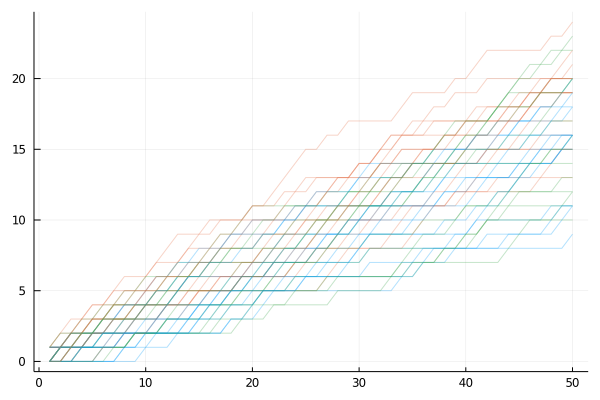

first win: 15.133333333333333+-3.24844285041017
ties: 18.6+-2.9228166454393167
second win: 16.266666666666666+-4.216746658379227


In [ ]:
simulate_game(3, 2, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

## Summery
* The history overwrite the prior pretty fast when looking on history
* when adding theory of mind from 0 to 1 the player succeed to exploit the inbalanced prior
* when going towards higher depth's we see that the effect above not working anymore (but the result is going to Nash-EQ). need more expirments
* we need to see how larger then 1 difference in theory of mind parameter affect the results

TODO:
* increase the num of rounds
* adding more example with different levels of theory of mind (2,0) , (0, 2)